## Import necessary libraries

In [1]:
#import necessary libraries
from effdet.data import DetectionDatset
from effdet.data.dataset_config import CocoCfg
from effdet.data.parsers import CocoParserCfg, create_parser
from pathlib import Path
import torch
import lightning as L
from effdet.data.transforms import RandomFlip, RandomResizePad, resolve_fill_color, ImageToNumpy, Compose, ResizePad
from app.models.effdet_model import EffDetLModel
from app.config.config import config

from app.model_loader import load_model

batch_size = 8


# model = load_model()

/home/jian6768/Desktop/Projects/OilPalmDetection_Effdet_Lightning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up Dataset and Dataloader

Note that data loader targets are in the format yxyx whereas model output is in the format xyxy. Torch metrics require xyxy format. When logging metrics, dataloader y values need to be converted before being fed into map computation. Note also impact on bounding boxes.
 

In [2]:
# ann_file = "_annotations.coco.json"
train_ann_file = "datasets/palm-oil-2/train/_annotations.coco.json"
train_data_dir = Path("datasets/palm-oil-2/train")

#set up parser config to be used in DetectionDataset instantiation

train_parser_cfg = CocoParserCfg(
    ann_filename=train_ann_file,
    has_labels=True
)


train_parser = create_parser("coco",cfg = train_parser_cfg)

train_dataset = DetectionDatset(
    data_dir = train_data_dir,
    parser=train_parser
)



# ann_file = "_annotations.coco.json"
validation_ann_file = "datasets/palm-oil-2/valid/_annotations.coco.json"
validation_data_dir = Path("datasets/palm-oil-2/valid")

#set up parser config to be used in DetectionDataset instantiation

validation_parser_cfg = CocoParserCfg(
    ann_filename=validation_ann_file,
    has_labels=True
)

validation_parser = create_parser("coco",cfg = validation_parser_cfg)

validation_dataset = DetectionDatset(
    data_dir = validation_data_dir,
    parser=validation_parser
)






loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
def create_custom_data_loader(
        dataset, 
        input_size,
        batch_size = 8, 
        is_training = False, 
        num_workers=1,
        mean=config.IMAGENET_DEFAULT_MEAN,
        std=config.IMAGENET_DEFAULT_STD,
        fill_color='mean',
        transform_fn=None,
        collate_fn=None,
        device="cuda"
        
        ):

    #Set up transform that will be used for dataset which will be fed into data loader. 
    if isinstance(input_size, tuple):
        img_size = input_size[-2:]
    else:
        img_size = input_size

    if transform_fn is not None:
        # transform_fn should accept inputs (img, annotations) from the dataset and return a tuple
        # of img, annotations for the data loader collate function.
        # The valid types of img and annotations depend on the dataset and collate abstractions used.
        # The default dataset outputs PIL Image and dict of numpy ndarrays or python scalar annotations.
        # The fast collate fn accepts ONLY numpy uint8 images and annotations dicts of ndarrays and python scalars
        transform = transform_fn
    else:

        fill_color = resolve_fill_color(fill_color, mean)

        if is_training:
            image_tfl = [
                RandomFlip(horizontal=True, prob=0.5),
                RandomResizePad(
                    target_size=img_size, interpolation="random", fill_color=fill_color),
                ImageToNumpy(),
                
                
            ]
            transform = Compose(image_tfl)

            
        else:
            image_tfl = [
                ResizePad(
                    target_size=img_size, interpolation="bilinear", fill_color=fill_color),
                ImageToNumpy(),
            ]

            transform = Compose(image_tfl)
    
    #Detection transform is 
    dataset.transform = transform

    # collate_fn = collate_fn or DetectionFastCollate(anchor_labeler=None)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_training,
        num_workers=num_workers,
        collate_fn=collate_fn,
        
    )

    return loader

In [4]:
def custom_collate(batch):
    """
    batch: list of (img, target)
        img:    np.ndarray, shape (C, H, W), dtype=uint8
        target: dict with keys 'img_idx', 'img_size', 'bbox', 'cls', 'img_scale'
    """

    batch_size = len(batch)

    # ---- 1. Stack images: (B, C, H, W) ----
    # all images same size (3, 512, 512)
    imgs = [torch.from_numpy(sample[0]) for sample in batch]  # each (C, H, W)
    imgs = torch.stack(imgs, dim=0)                           # (B, C, H, W)
    # imgs = imgs.float() / 255.0  
    imgs = imgs.float()  

    # ---- 2. Simple fields: img_idx, img_size, img_scale ----
    img_idx = torch.tensor([sample[1]["img_idx"] for sample in batch], dtype=torch.int64)

    img_size = torch.tensor(
        [sample[1]["img_size"] for sample in batch], dtype=torch.int32
    )  # (B, 2)

    img_scale = torch.tensor(
        [sample[1]["img_scale"] for sample in batch], dtype=torch.float32
    )  # (B,)

    # ---- 3. Variable-length bboxes & cls -> pad to max_det ----
    # Number of boxes per image
    num_boxes = [sample[1]["bbox"].shape[0] for sample in batch]
    max_det = max(num_boxes)

    # Initialize with -1 as padding (to match what you printed)
    bbox = torch.full(
        (batch_size, max_det, 4), -1.0, dtype=torch.float32
    )
    cls = torch.full(
        (batch_size, max_det), -1, dtype=torch.int32
    )

    for i, (_, target) in enumerate(batch):
        n = target["bbox"].shape[0]
        if n == 0:
            continue

        bbox[i, :n] = torch.from_numpy(target["bbox"]).to(torch.float32)
        cls[i, :n] = torch.from_numpy(target["cls"]).to(torch.int32)

    targets = {
        "img_idx": img_idx,
        "img_size": img_size,
        "bbox": bbox,
        "cls": cls,
        "img_scale": img_scale,
    }
    # print("mydetectioncollate used.")
    return imgs, targets

In [5]:
train_loader = create_custom_data_loader(train_dataset, input_size=config.image_size, is_training=True, batch_size=batch_size, num_workers = 2, collate_fn = custom_collate)
validation_loader = create_custom_data_loader(train_dataset, input_size=config.image_size, is_training=False,batch_size=batch_size, num_workers = 2, collate_fn = custom_collate)

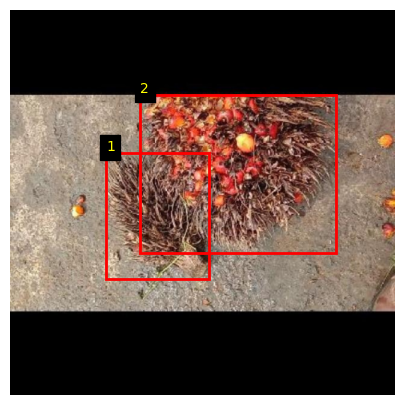

In [6]:
import matplotlib.pyplot as plt

imgs, targets = next(iter(train_loader))
img = imgs[0].cpu().detach()         # tensor shape (C, H, W)
img = img.permute(1, 2, 0).numpy()   # now shape (H, W, C)

plt.figure(figsize=(5,5))
plt.imshow(img.astype("uint8"))
plt.axis("off")

# If you'd like to overlay bounding boxes from your target:
boxes = targets["bbox"][0]  # first image’s boxes, shape (N,4)
labels = targets["cls"][0]  # corresponding labels


for i, box in enumerate(boxes):
    if box[0] < 0:             # assuming `-1` means padded/no box
        continue
    y_min, x_min, y_max, x_max = box
    # draw rectangle
    rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min-2, f"{labels[i].item()}",
                   color='yellow', fontsize=10, backgroundcolor="black")

## Set up Model

In [7]:
model_architecture="efficientdet_d0"
num_classes = 5

In [8]:
# #Uncomment when training. 

# trainer = L.Trainer(accelerator="gpu", max_epochs = 15)
# model_train = EffDetLModel(model_architecture=model_architecture, num_classes=5)
# trainer.fit(model_train, train_dataloaders=train_loader, val_dataloaders=validation_loader)


## Inference Example

In [ ]:
import matplotlib.pyplot as plt

img_idx = 5

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

#retrieve single image from validation loader. 
next(iter(validation_loader))
imgs, targets = next(iter(validation_loader))

imgs = imgs.to(device)

#create and load model. 
loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", bench_task = "predict")
# loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", model_architecture = model_architecture, num_classes = num_classes, bench_task = "predict", lr = 0.0002, batch_size = 8)
loaded_model.to("cuda")
loaded_model.eval()

#Predict using model
preds = loaded_model(imgs)

self.model_predict called


0
tensor([126.5788, 248.5328, 229.3455, 363.7408])
1
tensor([154.5661, 123.9152, 317.1136, 278.2112])
2
tensor([220.2766, 279.4601, 358.5688, 399.2712])
3
tensor([  3.2472, 113.6232, 174.0532, 294.5793])


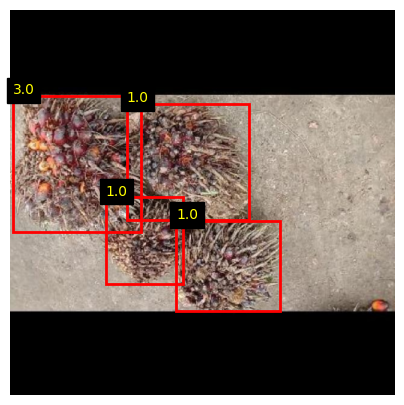

In [10]:
#move image to cpu. Change format to meet plt reqs. 
img = imgs[img_idx].cpu().detach()         # tensor shape (C, H, W)
img = img.permute(1, 2, 0).numpy()   # now shape (H, W, C)

plt.figure(figsize=(5,5))
plt.imshow(img.astype("uint8"))
plt.axis("off")

detections = preds[img_idx].detach().cpu()                 # (N, 6): x1,y1,x2,y2,score,label

scores = detections[:, 4]
keep   = scores > 0.3                    # choose a threshold you like

boxes  = detections[keep, :4]
labels = detections[keep, 5]
scores = scores[keep]

for i, box in enumerate(boxes):
    print(i)
    print(box)
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min-2, f"{labels[i].item()}",
                   color='yellow', fontsize=10, backgroundcolor="black")

